In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam

import matplotlib.pyplot as plt
import random
from tqdm import trange

from general_utils import AttrDict
from reward_induced.models.reward_predictor_model import RewardPredictorModel, R_CLASSES
from reward_induced.utils import *
from sprites_datagen.moving_sprites import MovingSpriteDataset
from sprites_datagen.rewards import *


/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=4,      # number of shapes per trajectory
        rewards=[AgentXReward, AgentYReward, TargetXReward, TargetYReward],
    )

In [4]:
dataset = MovingSpriteDataset(spec)
dataset[0]['rewards']

{'agent_x': array([0.4954996 , 0.5014269 , 0.50735414, 0.5132814 , 0.51920867,
        0.52513593, 0.5310632 , 0.53699046, 0.5429177 , 0.548845  ,
        0.55477226, 0.5606995 , 0.5666268 , 0.57255405, 0.5784813 ,
        0.5844086 , 0.59033585, 0.5962631 , 0.6021904 , 0.60811764,
        0.6140449 , 0.61997217, 0.62589943, 0.6318267 , 0.63775396,
        0.6436812 , 0.6496085 , 0.65553576, 0.661463  , 0.6673903 ],
       dtype=float32),
 'agent_y': array([0.8426982 , 0.84355545, 0.84441274, 0.84527   , 0.8461273 ,
        0.8469845 , 0.8478418 , 0.84869903, 0.8495563 , 0.85041356,
        0.85127085, 0.8521281 , 0.8529853 , 0.8538426 , 0.85469985,
        0.85555714, 0.8564144 , 0.8572717 , 0.8581289 , 0.8589862 ,
        0.85984343, 0.8607007 , 0.86155796, 0.86241525, 0.8632725 ,
        0.8641298 , 0.864987  , 0.86584425, 0.86670154, 0.8675588 ],
       dtype=float32),
 'target_x': array([0.6890846 , 0.6676088 , 0.64613295, 0.6246571 , 0.60318124,
        0.58170545, 0.5602296 , 0.

# Train reward-induced representations with **RPM image encoder**

In [5]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 20  # number of conditioning frames
T_future = 10  # number of future frames to predict rewards for
batch_size = 32

lr = 1e-3
n_iter = 10_000
log_interval = 1_000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# # DEBUG - check computation graph of the model
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# from torchviz import make_dot

# model = RewardPredictorModel(image_shape, n_frames, T_future).to(device)
# image = dataset[0]['images']
# image = torch.tensor(image).to(device)
# pred_rewards = model(image[:n_frames].unsqueeze(0),
#                      image[n_frames:].unsqueeze(0))['agent_x']

# make_dot(pred_rewards, params=dict(model.named_parameters())).render('RPM_comp_graph', format='png')
# make_dot(pred_rewards, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render('RPM_comp_graph_back_prop', format='png')

In [7]:
def train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True):
	losses = []
	model.to(device)
	print(f'[INFO] Training complete reward predictor model on device: {device} ...')

	for itr in trange(n_iter):
		images, rewards = generate_batch(dataset, batch_size, itr)

		reward_type_list = random.sample(R_CLASSES, k=3) if not is_complete else R_CLASSES
		# assume n_frames + T_future == len(images)
		pred_rewards = model(  # add batch dimension for images
			conditioning_frames=images[:, :n_frames].to(device), 
			future_frames=images[:, n_frames:].to(device),
			reward_type=reward_type_list
		)

		loss = 0
		for reward_type, pred_reward in pred_rewards.items():
			reward = torch.tensor(rewards[reward_type][:, n_frames:], 
						 dtype=torch.float32, device=device)
			loss += loss_fn(pred_reward, reward)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

	return losses

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

### (a) Train with complete reward annotation

In [9]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [10]:
losses_complete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1000/10000 [06:42<58:37,  2.56it/s] 

[1000 / 10000] RPM loss: 0.05867062136530876


 20%|██        | 2000/10000 [13:11<39:01,  3.42it/s]  

[2000 / 10000] RPM loss: 0.009363084100186825


 30%|███       | 3000/10000 [20:40<49:56,  2.34it/s]  

[3000 / 10000] RPM loss: 0.0038837518077343702


 40%|████      | 4000/10000 [28:26<39:27,  2.53it/s]  

[4000 / 10000] RPM loss: 0.0023617707192897797


 50%|█████     | 5000/10000 [34:02<32:19,  2.58it/s]

[5000 / 10000] RPM loss: 0.0012476233532652259


 60%|██████    | 6000/10000 [42:32<34:53,  1.91it/s]

[6000 / 10000] RPM loss: 0.0018310878658667207


 70%|███████   | 7000/10000 [49:44<21:23,  2.34it/s]

[7000 / 10000] RPM loss: 0.0011167427292093635


 80%|████████  | 8000/10000 [56:45<14:00,  2.38it/s]

[8000 / 10000] RPM loss: 0.0007745607872493565


 90%|█████████ | 9000/10000 [1:03:49<06:39,  2.50it/s]

[9000 / 10000] RPM loss: 0.0007210418116301298


100%|██████████| 10000/10000 [1:10:59<00:00,  2.35it/s]

[10000 / 10000] RPM loss: 0.000901362975127995


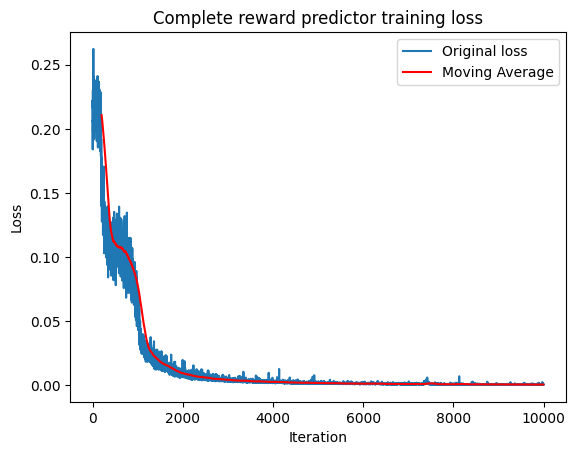

In [11]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Complete reward predictor training loss')
plt.legend()
plt.show()

In [12]:
PATH = 'complete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [13]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>

### (b) Train with incomplete reward annotation

In [14]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [15]:
losses_incomplete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=False)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1000/10000 [07:44<1:04:45,  2.32it/s]

[1000 / 10000] RPM loss: 0.05586288124322891


 20%|██        | 2000/10000 [14:51<1:01:30,  2.17it/s]

[2000 / 10000] RPM loss: 0.016164768487215042


 30%|███       | 3000/10000 [21:57<49:15,  2.37it/s]  

[3000 / 10000] RPM loss: 0.005784249864518642


 40%|████      | 4000/10000 [29:06<42:09,  2.37it/s]

[4000 / 10000] RPM loss: 0.0015810179756954312


 50%|█████     | 5000/10000 [36:18<36:00,  2.31it/s]

[5000 / 10000] RPM loss: 0.0017029047012329102


 60%|██████    | 6000/10000 [43:22<30:22,  2.20it/s]

[6000 / 10000] RPM loss: 0.0019024102948606014


 70%|███████   | 7000/10000 [50:34<21:11,  2.36it/s]

[7000 / 10000] RPM loss: 0.0009181970963254571


 80%|████████  | 8000/10000 [57:50<14:14,  2.34it/s]

[8000 / 10000] RPM loss: 0.0010653503704816103


 90%|█████████ | 9000/10000 [1:05:04<07:16,  2.29it/s]

[9000 / 10000] RPM loss: 0.0006020173314027488


100%|██████████| 10000/10000 [1:13:06<00:00,  2.28it/s]

[10000 / 10000] RPM loss: 0.0011743814684450626


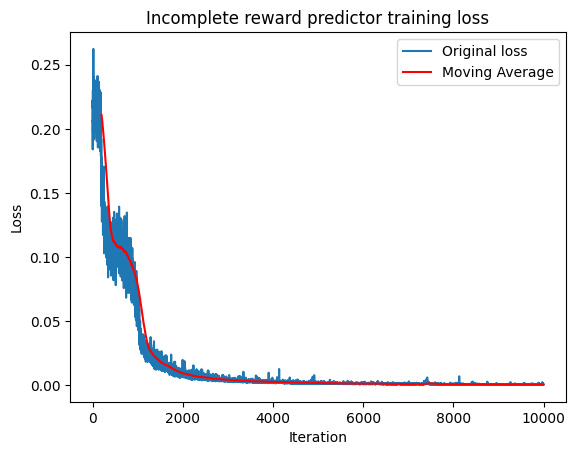

In [18]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Incomplete reward predictor training loss')
plt.legend()
plt.show()

In [16]:
PATH = 'incomplete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [17]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>